# Example: growth of perturbations

This example is similar to the simulations in [1909.11678](https://arxiv.org/abs/1909.11678)/[10.1103/PhysRevLett.124.061301](https://doi.org/10.1103/PhysRevLett.124.061301).

## Set up Julia environment

In [2]:
import Pkg
Pkg.activate(mktempdir())

Pkg.add("CSV")
Pkg.add("CairoMakie")
Pkg.add("NPZ")
Pkg.add("Unitful")
Pkg.add("Printf")
Pkg.develop(path=joinpath(@__DIR__, ".."))  # Load version of UltraDark in this repo

In [3]:
using CairoMakie
using CSV
using NPZ
using Random: randn!
using Test
using UltraDark
using Unitful

In [4]:
Threads.nthreads()

8

## Units

In [5]:
mpl = uconvert(u"kg", sqrt(Unitful.ħ * Unitful.c / Unitful.G))
Mpl = uconvert(u"kg", sqrt(Unitful.ħ * Unitful.c / 8 / π / Unitful.G))

4.341358399139357e-9 kg

In [6]:
tpl = uconvert(u"s", sqrt(Unitful.ħ * Unitful.G / Unitful.c^5))

5.391246448313604e-44 s

In [7]:
lpl = uconvert(u"m", sqrt(Unitful.ħ * Unitful.G / Unitful.c^3))

1.616255024423705e-35 m

In [8]:
m = 6.35e-6Mpl

2.756762583453492e-14 kg

In [9]:
hbar = Unitful.ħ
G = Unitful.G
Ωm = 1.0

1.0

In [10]:
H0 = sqrt(1/3)m / (tpl*mpl)

1.3564506032609175e37 s^-1

In [11]:
t_code = (3 / 8 / π * H0^2 * Ωm)^(-1/2)

2.1338079037120107e-37 s

In [12]:
uconvert(u"s", t_code)

2.1338079037120107e-37 s

In [13]:
l_code = (hbar / m)^(1/2) * (3 / 8 / π * H0^2 * Ωm)^(-1/4)

2.8570382677283864e-29 J^1/2 s kg^-1/2

In [14]:
uconvert(u"m", l_code)

2.857038267728386e-29 m

In [15]:
m_code = (hbar / m)^(3/2) * (3 / 8 / π * H0^2 * Ωm)^(+1/4) / G

0.007674176966402799 J^3/2 s^3 kg^-1/2 m^-3

In [16]:
uconvert(u"kg", m_code)

0.007674176966402799 kg

## Define initial conditions

In [17]:
function x(k, a)
    m = 1
    H0 = 1
    k^2 / (m * H0 * a^0.5)
end

function δ_g(x)
    if x == 0
        0
    else
        -(3/x^2 - 1) * cos(x) - 3/x * sin(x)
    end
end

function S_g(x)
    if x == 0
        0
    else
        (6/x^3 + 3/x) * cos(x) + (6/x^2 - 1) * sin(x)
    end
end

function propagate_to!(grids, A_k, a)
    # Density perturbation
    δ_k = similar(grids.ρk)
    δ_k .= A_k .* δ_g.(x.(grids.rk, a))
    δ_k[1, 1, 1] = 0

    # Phase perturbation
    S_k = similar(grids.ρk)
    S_k .= A_k .* S_g.(x.(grids.rk, a))

    # Field perturbation
    grids.ψx .= (1+0im .+ grids.rfft_plan \ δ_k).^0.5 .* exp.(im .* (grids.rfft_plan \ S_k))
    
    return
end

function propagate_to(grids, A_k, a)
    grids_new = deepcopy(grids)
    
    propagate_to!(grids_new, A_k, a)
    
    grids_new
end

propagate_to (generic function with 1 method)

In [18]:
a_end = 1
t_end = (2.0/(3.0 * H0))
t_end_code_units = uconvert(Unitful.NoUnits, t_end/t_code)

function a(t)
    a_end * (t/t_end_code_units)^(2/3)
end

function t(a)
    t_end_code_units * (a/a_end)^(3/2)
end

t (generic function with 1 method)

In [19]:
L_horizon_end = uconvert(Unitful.NoUnits, 1/(H0*tpl) * lpl / l_code)

0.7735718587191165

In [20]:
resol = 64
box_length = 20 * L_horizon_end

15.47143717438233

In [21]:
# Define initial conditions

a_init = 1e0
a_final = 1e2

@show t_init = t(a_init)
@show t_final = t(a_final)

grids = UltraDark.Grids(box_length, resol)

A_k = similar(grids.ρk)
randn!(A_k)
A_k[grids.rk .> maximum(grids.rk[1, 1, :])] .= 0
A_k *= 1e-3

propagate_to!(grids, A_k, a_init)

t_init = t(a_init) = 0.23032943298089031
t_final = t(a_final) = 230.32943298089032


In [22]:
output_dir = "$(pwd())/output"
num_saves = 100

output_a = exp10.(range(log10(a_init), log10(a_final), num_saves))

output_times = t.(output_a)

output_config = OutputConfig(output_dir, output_times, summary_statistics=(Summary.SimulationTime,Summary.MeanDensity,Summary.MaxDensity,Summary.RmsDensityContrast,Summary.ScaleFactor,Summary.TimeStep))

options = Config.SimulationConfig(a=a)

SimulationConfig(a, 0.7853981633974483, 1.0e-6, TimeStepOptions(10, 1.0))

In [23]:
options

SimulationConfig(a, 0.7853981633974483, 1.0e-6, TimeStepOptions(10, 1.0))

## Run simulation

In [24]:
@time simulate!(grids, options, output_config)

 20.298660 seconds (7.96 M allocations: 3.478 GiB, 1.28% gc time, 24.76% compilation time: 6% of which was recompilation)


## Check output

In [25]:
summary = CSV.File("$(output_config.directory)/summary.csv");

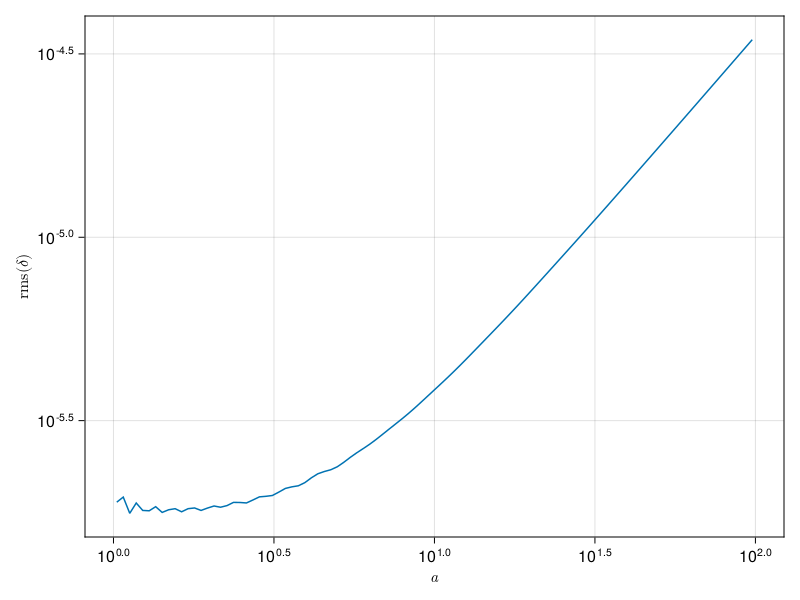

In [26]:
fig_rms = Figure()
ax = Axis(
    fig_rms[1,1], 
    xlabel=L"$a$",
    ylabel=L"$\mathrm{rms}(\delta)$",
    xscale=log10,
    yscale=log10,
)
lines!(
    summary.a, summary.δx_rms;
)
save("rms_delta.pdf", fig_rms)
fig_rms

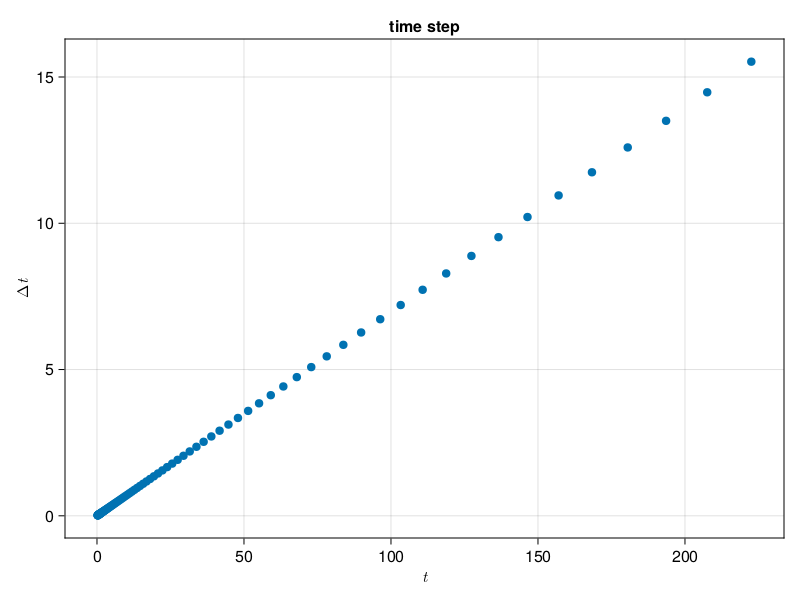

In [27]:
fig_Δt = Figure()
ax_Δt = Axis(
    fig_Δt[1, 1],
    title="time step",
    xlabel=L"$t$",
    ylabel=L"$\Delta t$",
)
scatter!(
    summary.t, summary.Δt,
)
fig_Δt

In [28]:
rho_init = npzread("$(output_config.directory)/rho_1.npy");
rho_last = npzread("$(output_config.directory)/rho_$(length(output_times)).npy");

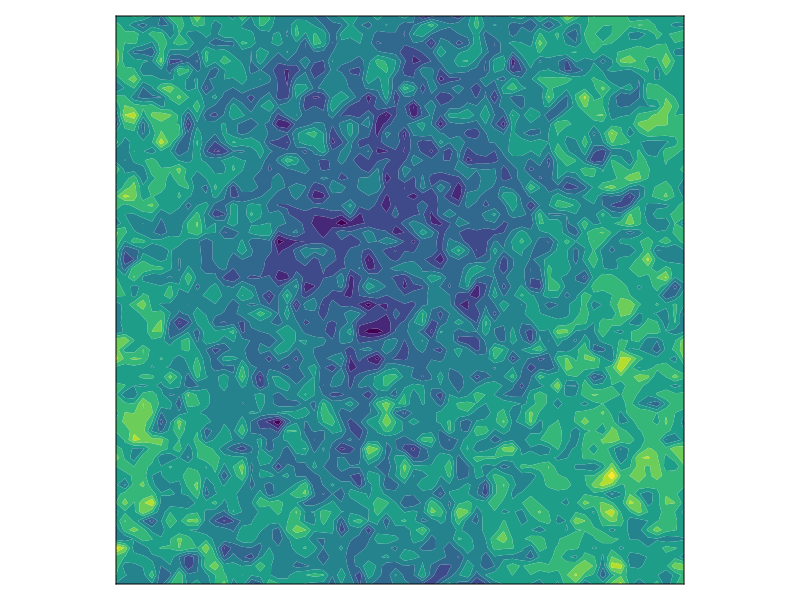

In [29]:
fig_init = Figure()
ax_init = Axis(
    fig_init[1, 1],
    aspect=DataAspect(),
)
hidedecorations!(ax_init)

contourf!(ax_init, rho_init[1, :, :] .- 1)

fig_init

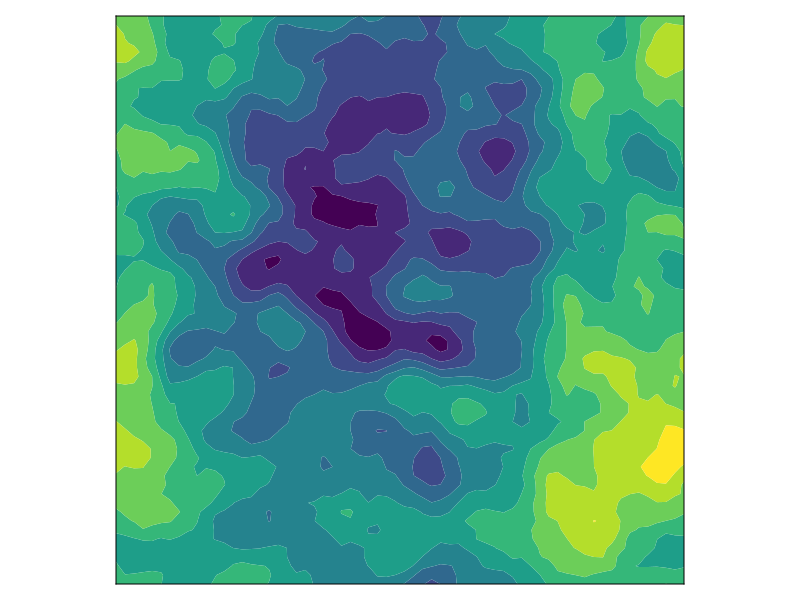

In [30]:
fig_last = Figure()
ax_last = Axis(
    fig_last[1, 1],
    aspect=DataAspect(),
)
hidedecorations!(ax_last)

contourf!(ax_last, rho_last[1, :, :] .- 1)

fig_last

In [31]:
fig_anim = Figure()
ax_anim = Axis(
    fig_anim[1, 1],
    aspect=DataAspect(),
)

hidedecorations!(ax_anim)

δ_lims = extrema(rho_last.-1)

cb_density = Colorbar(
    fig_anim[1, 2],
    limits=δ_lims,
    label = L"$\rho/\rho_{\text{crit}} - 1$",
)

frame = Observable(1)

rho = lift(i -> npzread(joinpath(output_config.directory, "rho_$(i).npy"))[:, :, resol÷2], frame)
δ = @lift($rho .- 1)

contourf!(
    ax_anim,
    grids.x[:, 1, 1], grids.y[1, :, 1],
    δ,
    colorrange = δ_lims,
)

Record(fig_anim, 1:length(output_times); framerate = 15) do f
    frame[] = f
end

VideoStream(Base.PipeEndpoint(RawFD(53) open, 0 bytes waiting), Process(`ffmpeg -y -loglevel quiet -threads 16 -framerate 15 -pixel_format rgb24 -f rawvideo -s:v 800x600 -r 15 -i pipe:0 -vf vflip -profile:v high422 -crf 20 -preset slow -c:v libx264 -pix_fmt yuv420p -an '/tmp/jl_ajhPQb/##video#227.mp4'`, ProcessRunning), CairoMakie.Screen{CairoMakie.IMAGE}(Scene (800px, 600px):
  0 Plots
  2 Child Scenes:
    ├ Scene (800px, 600px)
    └ Scene (800px, 600px), Cairo.CairoSurfaceImage{ColorTypes.ARGB32}(Ptr{Nothing} @0x0000000009d5d000, 800.0, 600.0, ColorTypes.ARGB32[ARGB32(1.0N0f8,1.0N0f8,1.0N0f8,1.0N0f8) ARGB32(1.0N0f8,1.0N0f8,1.0N0f8,1.0N0f8) … ARGB32(1.0N0f8,1.0N0f8,1.0N0f8,1.0N0f8) ARGB32(1.0N0f8,1.0N0f8,1.0N0f8,1.0N0f8); ARGB32(1.0N0f8,1.0N0f8,1.0N0f8,1.0N0f8) ARGB32(1.0N0f8,1.0N0f8,1.0N0f8,1.0N0f8) … ARGB32(1.0N0f8,1.0N0f8,1.0N0f8,1.0N0f8) ARGB32(1.0N0f8,1.0N0f8,1.0N0f8,1.0N0f8); … ; ARGB32(1.0N0f8,1.0N0f8,1.0N0f8,1.0N0f8) ARGB32(1.0N0f8,1.0N0f8,1.0N0f8,1.0N0f8) … ARGB32(1.0N0f8,1.0N0f8,1.0N0f8,1.0N0f8) ARGB32(1.0N0f8,1.0N0f8,1.0N0f8,1.0N0f8); ARGB32(1.0N0f8,1.0N0f8,1.0N0f8,1.0N0f8) ARGB32(1.0N0f8,1.0N0f8,1.0N0f8,1.0N0f8) … ARGB32(1.0N0f8,1.0N0f8,1.0N0f8,1.0N0f8) ARGB32(1.0N0f8,1.0N0f8,1.0N0f8,1.0N0f8)]), Cairo.CairoContext(Ptr{Nothing} @0x000000000550dd80, Cairo.CairoSurfaceImage{ColorTypes.ARGB32}(Ptr{Nothing} @0x0000000009d5d000, 800.0, 600.0, ColorTypes.ARGB32[ARGB32(1.0N0f8,1.0N0f8,1.0N0f8,1.0N0f8) ARGB32(1.0N0f8,1.0N0f8,1.0N0f8,1.0N0f8) … ARGB32(1.0N0f8,1.0N0f8,1.0N0f8,1.0N0f8) ARGB32(1.0N0f8,1.0N0f8,1.0N0f8,1.0N0f8); ARGB32(1.0N0f8,1.0N0f8,1.0N0f8,1.0N0f8) ARGB32(1.0N0f8,1.0N0f8,1.0N0f8,1.0N0f8) … ARGB32(1.0N0f8,1.0N0f8,1.0N0f8,1.0N0f8) ARGB32(1.0N0f8,1.0N0f8,1.0N0f8,1.0N0f8); … ; ARGB32(1.0N0f8,1.0N0f8,1.0N0f8,1.0N0f8) ARGB32(1.0N0f8,1.0N0f8,1.0N0f8,1.0N0f8) … ARGB32(1.0N0f8,1.0N0f8,1.0N0f8,1.0N0f8) ARGB32(1.0N0f8,1.0N0f8,1.0N0f8,1.0N0f8); ARGB32(1.0N0f8,1.0N0f8,1.0N0f8,1.0N0f8) ARGB32(1.0N0f8,1.0N0f8,1.0N0f8,1.0N0f8) … ARGB32(1.0N0f8,1.0N0f8,1.0N0f8,1.0N0f8) ARGB32(1.0N0f8,1.0N0f8,1.0N0f8,1.0N0f8)]), Ptr{Nothing} @0x0000000008a38bd0), 1.0, 6, false, CairoMakie.ScreenConfig(1.0, 0.75, :best, false, false)), ColorTypes.RGB{FixedPointNumbers.N0f8}[RGB{N0f8}(1.0,1.0,1.0) RGB{N0f8}(1.0,1.0,1.0) … RGB{N0f8}(1.0,1.0,1.0) RGB{N0f8}(1.0,1.0,1.0); RGB{N0f8}(1.0,1.0,1.0) RGB{N0f8}(1.0,1.0,1.0) … RGB{N0f8}(1.0,1.0,1.0) RGB{N0f8}(1.0,1.0,1.0); … ; RGB{N0f8}(1.0,1.0,1.0) RGB{N0f8}(1.0,1.0,1.0) … RGB{N0f8}(1.0,1.0,1.0) RGB{N0f8}(1.0,1.0,1.0); RGB{N0f8}(1.0,1.0,1.0) RGB{N0f8}(1.0,1.0,1.0) … RGB{N0f8}(1.0,1.0,1.0) RGB{N0f8}(1.0,1.0,1.0)], "/tmp/jl_ajhPQb/##video#227.mp4", Makie.VideoStreamOptions("mp4", 15, 20, "high422", "yuv420p", nothing, "quiet", "pipe:0", true))